In [ ]:
import pandas as pd
import numpy as np
import os
from data_utils import build_pulse, filter_pulse, basic_processing
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.iolib.smpickle import load_pickle

In [ ]:
# Periods: https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html
week_start = 28
week_end = 45

In [ ]:
file_path = f"processed_data/{week_start}_{week_end}_pulse.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    df = build_pulse(week_start, week_end)
    df = filter_pulse(df, verbose=True)
    df = basic_processing(df)
    df.to_csv(file_path, index=False)

Opening local file for pulse week28
Opening local file for pulse week29
Opening local file for pulse week30
Opening local file for pulse week31
Opening local file for pulse week32
Opening local file for pulse week33
Opening local file for pulse week34
Opening local file for pulse week35
Opening local file for pulse week36
Opening local file for pulse week37
Opening local file for pulse week38
Opening local file for pulse week39
Opening local file for pulse week40
Opening local file for pulse week41
Opening local file for pulse week42
Opening local file for pulse week43


MemoryError: Unable to allocate 1.66 GiB for an array with shape (218, 1019671) and data type float64

In [47]:
df[(df["Eligible"] == 1) & (df['Post'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.661219
0    0.338781
Name: Received_CTC, dtype: float64

1) Less than $25,000  
2) $25,000 - $34,999  
3) $35,000 - $49,999   
4) $50,000 - $74,999   
5) $75,000 - $99,999   
6) $100,000 - $149,999   
7) $150,000 - $199,999
8) $200,000 and above 

In [182]:
income_threshold = 7
df_m = df.query(f"(Income < {income_threshold})")

In [183]:
df_m["Eligible"] = (df_m['Number_of_kids'] > 1).astype(int) * df_m["Eligible"] 

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_10844\3202648632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m["Eligible"] = (df_m['Number_of_kids'] > 1).astype(int) * df_m["Eligible"]


In [184]:
df_m[(df_m["Eligible"] == 1) & (df_m['Post'] == 1)]["Received_CTC"].value_counts(normalize=True)

1    0.761684
0    0.238316
Name: Received_CTC, dtype: float64

In [185]:
df_m.shape

(1192374, 21)

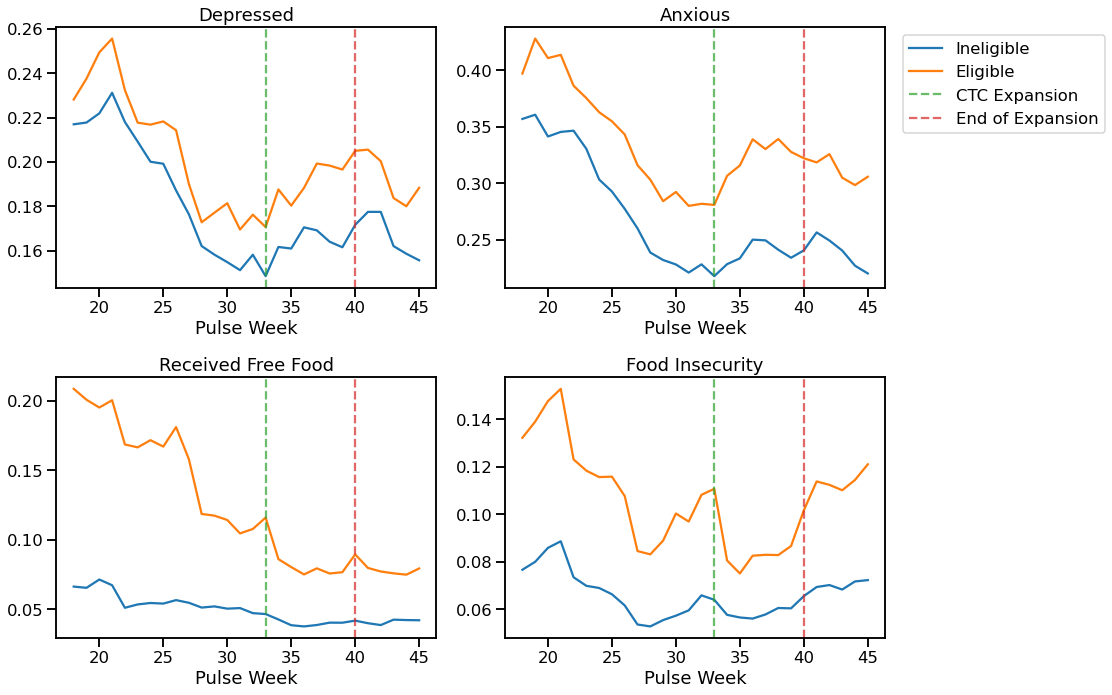

In [186]:
sns.set_context("talk")
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
dependent_vars = ['Depressed', 'Anxious', 'Received_Free_Food', 'Food_Insecurity']
titles = ['Depressed', 'Anxious', 'Received Free Food', 'Food Insecurity']
counter = 0
for i in range(2):
    for j in range(2):
        df_m.pivot_table(columns="Eligible", index="Week", values=dependent_vars[counter]).plot(ax=ax[i, j], legend=False)
        ax[i, j].axvline(33, c='tab:green', linestyle="--", alpha=.7)
        ax[i, j].axvline(40, c='tab:red', linestyle="--", alpha=.7)
        ax[i, j].set_title(titles[counter])
        ax[i, j].set_xlabel("Pulse Week")
        counter += 1
ax[0, 1].legend(["Ineligible", "Eligible", "CTC Expansion", "End of Expansion"], loc="upper right", bbox_to_anchor=(1.6, 1))
fig.tight_layout();
fig.savefig(f"figures/trendlines_incomegroup_{income_threshold}.png", dpi=300, facecolor=fig.get_facecolor())

In [151]:
df_m.columns

Index(['Received_CTC', 'Eligible', 'Post', 'Week', 'Treat', 'Number_of_kids',
       'Depressed_or_Anxious', 'Depressed', 'Anxious',
       'Difficulty_with_Expenses', 'Food_Insecurity', 'Rent_Confidence',
       'Vaccinated', 'Enrolled_in_SNAP', 'Worked_in_last_week', 'Income',
       'Education', 'Age', 'Received_EBT_card', 'Received_Free_Food',
       'Household_Weight'],
      dtype='object')

In [152]:
control_list = ['']
controls = " + ".join(control_list)

In [153]:
dids = []
for var in dependent_vars:
    formula = f"{var} ~  Eligible + Post + {controls} + Treat"
    basic_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
        ).fit(cov_type="HC1"))
    basic_did.save(f"models/{var}_did_model_group_{income_threshold}.p")
    dids.append(basic_did)

In [154]:
summary_col([*dids], stars=True)

,Depressed,Anxious,Received_Free_Food,Food_Insecurity
Intercept,0.2077***,0.2829***,0.0554***,0.0917***
,(0.0010),(0.0011),(0.0006),(0.0008)
Eligible,0.0255***,0.0596***,0.0756***,0.0639***
,(0.0018),(0.0020),(0.0014),(0.0016)
Post,-0.0183***,-0.0341***,-0.0073***,-0.0108***
,(0.0021),(0.0023),(0.0013),(0.0017)
Treat,-0.0023,0.0192***,-0.0304***,-0.0317***
,(0.0040),(0.0044),(0.0030),(0.0034)
R-squared,0.0012,0.0050,0.0161,0.0086
R-squared Adj.,0.0012,0.0050,0.0161,0.0086


In [155]:
fe_dids = []
for var in dependent_vars:
    formula = f"{var} ~  Eligible + C(Week) + {controls} + Treat"
    model_path = f"models/{var}_fe_model_group_{income_threshold}.p"
    if os.path.exists(model_path):
        print("Loading", var, "locally")
        fixed_effects_did = load_pickle(model_path)
    fixed_effects_did = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
            ).fit(cov_type="HC1"))
    fixed_effects_did.save(model_path)
    fe_dids.append(fixed_effects_did)


## Fixed Effects Results:

In [156]:
summary_col([*fe_dids], stars=True, regressor_order=["Treat"], drop_omitted=True)

,Depressed,Anxious,Received_Free_Food,Food_Insecurity
Treat,-0.0016,0.0205***,-0.0300***,-0.0316***
,(0.0040),(0.0044),(0.0030),(0.0034)
R-squared,0.0043,0.0122,0.0183,0.0102
R-squared Adj.,0.0043,0.0122,0.0182,0.0102


In [157]:
event_studies = []
for var in dependent_vars:
    formula = f"{var} ~ C(Week)*Eligible"
    event_study = (
        sm.WLS.from_formula(
            formula,
            data=df_m,
            weights=df_m['Household_Weight']
            ).fit(cov_type='HC1'))
    event_study.save(f"models/{var}_event_study_group_{income_threshold}.p")
    event_studies.append(event_study)

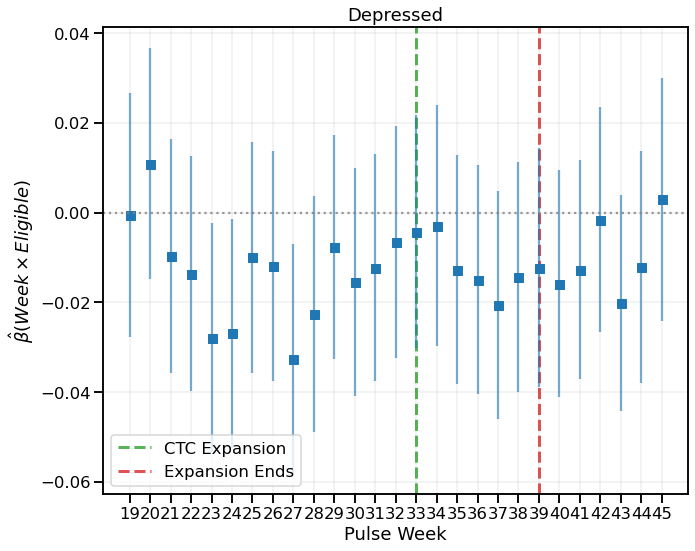

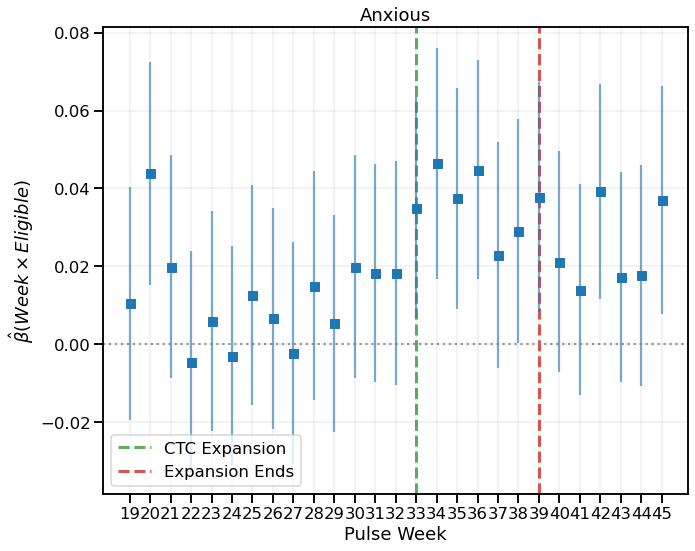

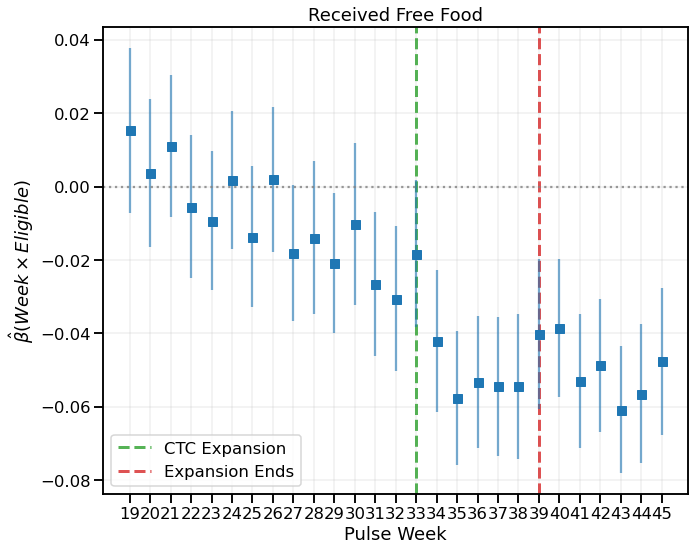

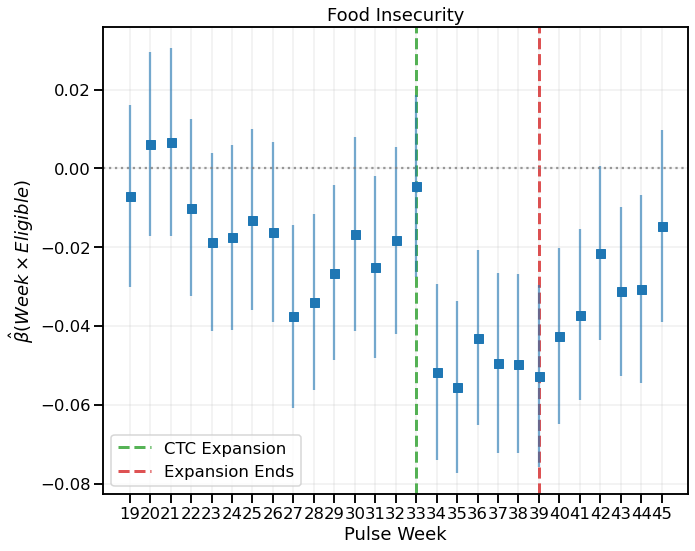

In [160]:
counter=0
for event_study in event_studies:
    estimates = pd.DataFrame({"coef": event_study.params, "std_err":event_study.HC1_se, "low": event_study.conf_int()[0], "high": event_study.conf_int()[1]})
    estimates = estimates.reset_index().rename({"index": "name"}, axis=1)
    did_estimates = estimates[estimates['name'].str.startswith('C(Week)[T.') & estimates['name'].str.endswith('Eligible')]
    did_estimates = did_estimates.reset_index(drop=True)
    did_estimates['Week'] = range(df_m['Week'].astype(int).min()+1, df_m['Week'].astype(int).max()+1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.axvline(14, c="tab:green", alpha=.8, linestyle="--", linewidth=3, label="CTC Expansion")
    ax.axvline(20, c="tab:red", alpha=.8, linestyle="--", linewidth=3, label="Expansion Ends")
    ax.errorbar(did_estimates.index, did_estimates['coef'], yerr=did_estimates['high']-did_estimates['coef'], alpha=.6, c="tab:blue", fmt='none')
    ax.plot(did_estimates['coef'], "s")
    # ax.plot(did_estimates['low'], "s", c="tab:blue")
    # ax.plot(did_estimates['high'], "s", c="tab:blue")
    ax.axhline(0, c="grey", alpha=.8, linestyle=":")
    ax.grid(alpha=.2)
    ax.legend(loc="lower left")

    ax.set_xlabel("Pulse Week")
    ax.set_ylabel(r"$\hat{\beta} (Week \times Eligible)$")
    ax.set_title(titles[counter])
    counter+=1

    ax.set_xticks(did_estimates.index, did_estimates['Week'])

    fig.tight_layout()


In [42]:
# estimates = pd.DataFrame({"coef": event_study.params, "std_err":event_study.HC1_se, "low": event_study.conf_int()[0], "high": event_study.conf_int()[1]})
# estimates = estimates.reset_index().rename({"index": "name"}, axis=1)
# did_estimates = estimates[estimates['name'].str.startswith('C(WEEK)[T.') & estimates['name'].str.endswith('CTC_Eligible')]
# did_estimates = did_estimates.reset_index(drop=True)
# did_estimates['week'] = range(df['WEEK'].min()+1, df['WEEK'].max()+1)

In [43]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# ax.axvline(14.5, c="tab:green", alpha=.8, linestyle="--", linewidth=3, label="CTC Expansion")
# ax.axvline(20.5, c="tab:red", alpha=.8, linestyle="--", linewidth=3, label="Expansion Ends")
# ax.errorbar(did_estimates.index, did_estimates['coef'], yerr=did_estimates['high']-did_estimates['coef'], alpha=.6, c="tab:blue", fmt='none')
# ax.plot(did_estimates['coef'], "s")
# # ax.plot(did_estimates['low'], "s", c="tab:blue")
# # ax.plot(did_estimates['high'], "s", c="tab:blue")
# ax.axhline(0, c="grey", alpha=.8, linestyle=":")
# ax.grid(alpha=.2)
# ax.legend(loc="lower left")

# ax.set_xlabel("Pulse Week")
# ax.set_ylabel(r"$\hat{\beta} (Week \times Treat)$")
# ax.set_title(f"{dependent}")

# ax.set_xticks(did_estimates.index, did_estimates['week'])

# fig.tight_layout()